In [31]:
import tensorflow as tf
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import skimage.color as color

In [32]:
#leaky relu
def lrelu(x, leak=0.2, name="lrelu", alt_relu_impl=False):

    with tf.variable_scope(name):
        if alt_relu_impl:
            f1 = 0.5 * (1 + leak)
            f2 = 0.5 * (1 - leak)
            # lrelu = 1/2 * (1 + leak) * x + 1/2 * (1 - leak) * |x|
            return f1 * x + f2 * abs(x)
        else:
            return tf.maximum(x, leak*x)


#instance normalize
def instance_norm(x):
    with tf.variable_scope("instance_norm"):
        epsilon = 1e-5
        mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
        scale = tf.get_variable('scale',[x.get_shape()[-1]], 
            initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.02))
        offset = tf.get_variable('offset',[x.get_shape()[-1]],initializer=tf.constant_initializer(0.0))
        out = scale*tf.div(x-mean, tf.sqrt(var+epsilon)) + offset

        return out

In [40]:
def general_conv2d(inputconv, filters, kernel_size, strides, do_norm=True, do_relu=True, relufactor=0, name="conv2d"):
    stddev=0.02
    with tf.variable_scope(name, reuse = True):
        conv = tf.contrib.layers.conv2d(inputs=inputconv,
                                       num_outputs=filters,
                                       kernel_size=kernel_size,
                                       stride=strides,
                                       activation_fn = None,
                                       weights_initializer = tf.truncated_normal_initializer(stddev=stddev),
                                       scope=name)

        if do_norm:
            conv = instance_norm(conv)

        if do_relu:
            if(relufactor == 0):
                conv = tf.nn.relu(conv,"relu")
            else:
                conv = lrelu(conv, relufactor, "lrelu")
        return conv

载入图像，并做卷积，输出中间层的显示

Tensor("strided_slice_92:0", shape=(112, 112, 3), dtype=float32)


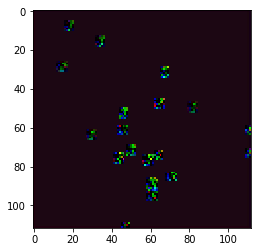

In [54]:
import tensorflow as tf;    
import matplotlib.pyplot as plt

filters = 64
kernel_size = 3
path = 'F:\\Project_Yang\\Database\\sparse_image4_1000bmp\\0_mask.bmp'  
file_queue = tf.train.string_input_producer([path]) #创建输入队列  
image_reader = tf.WholeFileReader()  
_, image = image_reader.read(file_queue)  
image = tf.image.decode_bmp(image)
image_batch = tf.reshape(image,[1,224,224,3],"reshape")
image_batch = tf.cast(image_batch, tf.float32)

with tf.name_scope("network") as scope:
    image = general_conv2d(image_batch, filters, kernel_size, 1, name = "1111")
    image = general_conv2d(image, filters, kernel_size, 1, name = "2221")
    image = general_conv2d(image, filters * 2, kernel_size, 2, name = "3331")
    image = general_conv2d(image, 3, kernel_size, 1, name = "4441")
    
  
with tf.Session() as sess:  
    coord = tf.train.Coordinator() #协同启动的线程  
    threads = tf.train.start_queue_runners(sess=sess, coord=coord) #启动线程运行队列  
    init = tf.global_variables_initializer()
    sess.run(init)
    sess.run(image)  
    coord.request_stop() #停止所有的线程  
    coord.join(threads)  
    print(image[0])
    image_uint8 = tf.image.convert_image_dtype(image[0], dtype = tf.uint8)
    plt.imshow(image_uint8.eval())
    plt.show()
        